In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


# Mall Customer Segmentation Data

This final project is a Kaggle competition called [Mall Customer Segmentation Data](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/). This dataset is about finding the customer segments, as we act on the mall owner's behalf and investigate their membership card data. In this notebook, we will explore the data and use several unsupervised models to find the best way to cluster the customers.

We will use Unsupervised Machine Learning to find the relevant clusters. As taught in class, we will use algorithms like K-Means or Agglomerative (Hierarchical) clustering to find segments for the owner to target further.

# Motivation

I chose this dataset as it is a good example of a real-life problem a Machine Learning engineer would face. It allows me to apply the clustering methods we have learned and explore a new dataset. The hope for this project is that we can recommend which clustering method to use.

# Exploratory Data Analysis (EDA)

The data, as created by Choudhary (2012), consists of only one file, Mall_Customers.csv. We will load this file into a pandas data frame to explore the data.

Now, let us understand the data we have been given. Let us explore and check how many features we have and how the data looks.

In [2]:
import pandas as pd
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

print("--- Info ---")
df.info()

print("--- Features and observations ---")
print(df.columns) # number of features
print(df.size / df.columns.size) # number of observations

print("--- Describe ---")
describedDF = df.describe()
print(describedDF)

print("--- First few rows ---")
df.head() #display the first few rows

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
--- Features and observations ---
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
200.0
--- Describe ---
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


From our dataset, we can see that there are 200 observations and five features. It is quite a small dataset, so we want to look more closely at how the data is shaped. The five features are CustomerID, Gender, Age, Annual Income, and Spending Score. According to Choudhary (2012), the Spending Score is a value you assign to the customer based on your defined parameters, like customer behavior and purchasing data.

Let us look at the distribution of Gender, Age, Annual Income, and Spending Score. These distributions might already give us ideas about how many clusters we should consider.

Unique Gender:  2


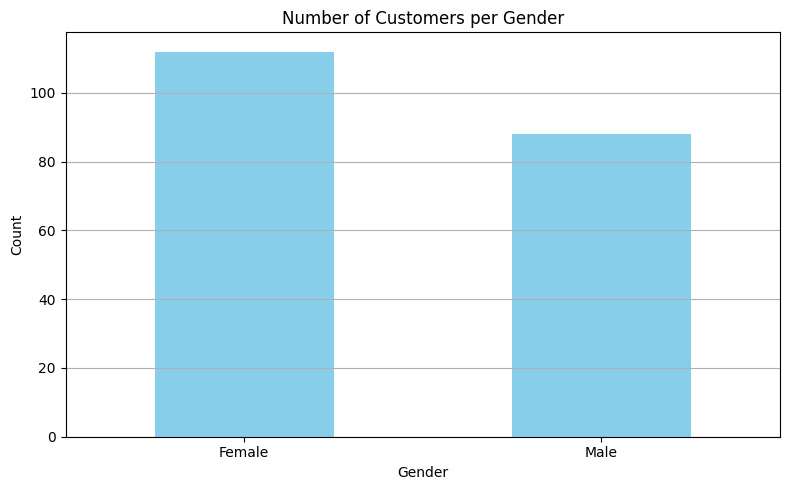

In [3]:
import matplotlib.pyplot as plt

print("Unique Gender: ", df['Gender'].nunique())

gender_counts = df['Gender'].value_counts().sort_index()
gender_counts.plot(kind='bar', figsize=(8, 5), color='skyblue')

plt.title("Number of Customers per Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

There are only two unique genders, so we have a pretty clean dataset. Secondly, the distribution of males to females is relatively even.

Missing Age values:  0


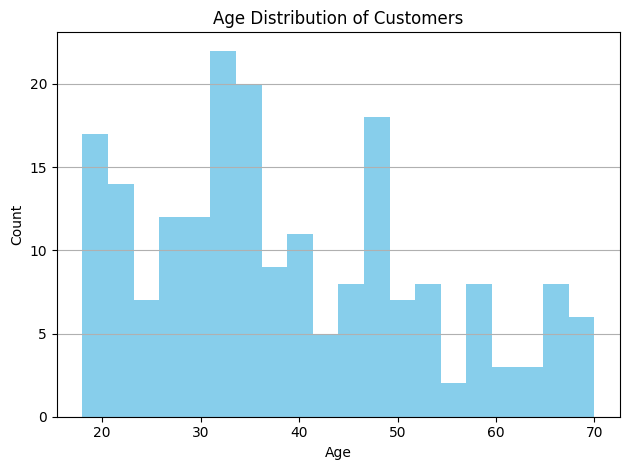

In [4]:
import matplotlib.pyplot as plt

print("Missing Age values: ", df['Age'].isna().sum())

df['Age'].plot(kind='hist', bins=20, color='skyblue')
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

There might be several clusters within the age feature. These clusters could be as follows: 18-24, 30-36, 46-50, 58-60, and 66-70. These are based on the peaks across the age data. There is also no missing data, so we do not need to do any special iputation of data.

Missing Income values:  0


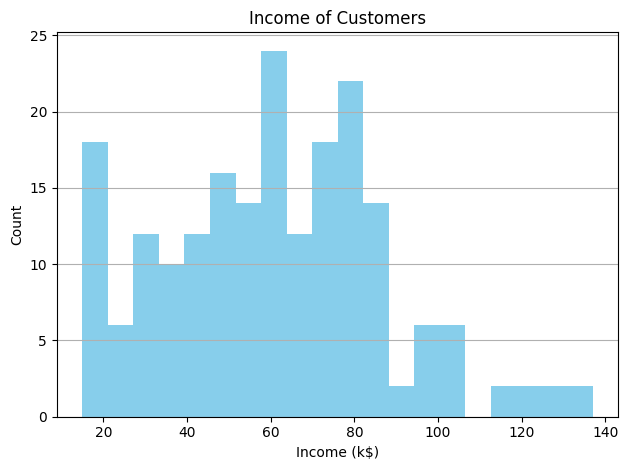

In [5]:
import matplotlib.pyplot as plt

print("Missing Income values: ", df['Annual Income (k$)'].isna().sum())

df['Annual Income (k$)'].plot(kind='hist', bins=20, color='skyblue')
plt.title("Income of Customers")
plt.xlabel("Income (k$)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The 'income of customers' feature looks similar to a normal distribution. Some outliers could be at the top of the range, but I will include them for now. There is also no missing data.

Missing Spending Score values:  0


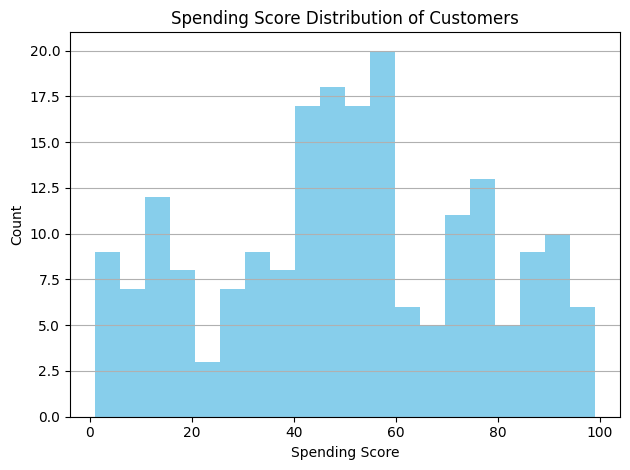

In [6]:
import matplotlib.pyplot as plt

print("Missing Spending Score values: ", df['Spending Score (1-100)'].isna().sum())

df['Spending Score (1-100)'].plot(kind='hist', bins=20, color='skyblue')
plt.title("Spending Score Distribution of Customers")
plt.xlabel("Spending Score")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Again, looking at the data for the spending score feature, we might consider 4-5 clusters as we saw with the age feature. There are no missing values.

## Clean/Transform the Data

From our initial exploration, the data looks good. There are no nulls, and the data is evenly spread. One thing I did not do was identify the potential for outliers on the income feature, but we will ignore those for now. Now, let us do some feature engineering.

Firstly, let us drop the ID feature as it is not relevant. We will also encode male/female into 0/1 using a LabelEncoder.

Lastly, we will scale all the data to ensure we do not have any sensitivity when we do our modelling.

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Drop CustomerID
df = df.drop('CustomerID', axis=1)

# Encode Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# Standardize
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
scaler = StandardScaler()
X = scaler.fit_transform(df[features])

## Correlation

Let us check the correlation matrix to see how highly each feature is related to the others.

In [8]:
df.corr()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
Gender,1.000000,0.060867,0.056410,-0.058109
Age,0.060867,1.000000,-0.012398,-0.327227
Annual Income (k$),0.056410,-0.012398,1.000000,0.009903
Spending Score (1-100),-0.058109,-0.327227,0.009903,1.000000


<Axes: >

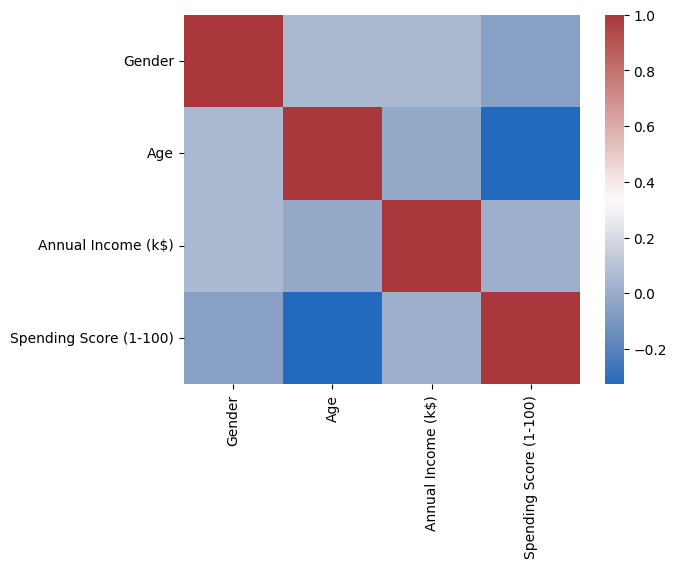

In [9]:
import seaborn as sns

sns.heatmap(data=df.corr(), cmap="vlag")

The correlation matrix shows that spending score and age are more correlated than any other feature. Nevertheless, the correlation is still low at 0.33. This shows that the relationship between spending score and age isn't likely colinear (we would expect to see 0.9 or above). All the other relationships have even lower correlation values, which means they are all independent.

We want to do a PCA analysis now. This might help us visualize clusters and check how many features explain the variance in the data.

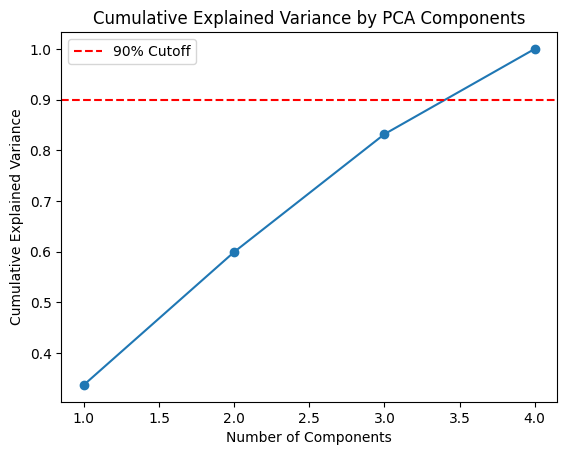

In [10]:
from sklearn.decomposition import PCA
import numpy as np

pca1 = PCA().fit(X)
cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Cutoff')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.show()

Firstly, we want to understand the explained variance. We can see here in the cumulative chart that the first component is roughly 0.3 of the variance. The second component makes this 0.6, and the third component makes this 0.8. If we wanted to reduce the dimensions of this data, we would want to use a 90% cutoff. However, in this scenario, it makes no sense, as that would be the four features. What we do want to do is help visualize and project the data onto some plots.

Now, we will use a PCA of two and three components. The PCA with two components will allow us to visualize in 2D, and the PCA with three will allow us to visualize in 3D.

In [11]:
from sklearn.decomposition import PCA

# For use of our 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"Explained variance: {pca.explained_variance_ratio_}")

# For use of our 3D vizualization
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

print(f"Explained variance (PCA of 3): {pca3.explained_variance_ratio_}")

Explained variance: [0.33690046 0.26230645]
Explained variance (PCA of 3): [0.33690046 0.26230645 0.23260639]


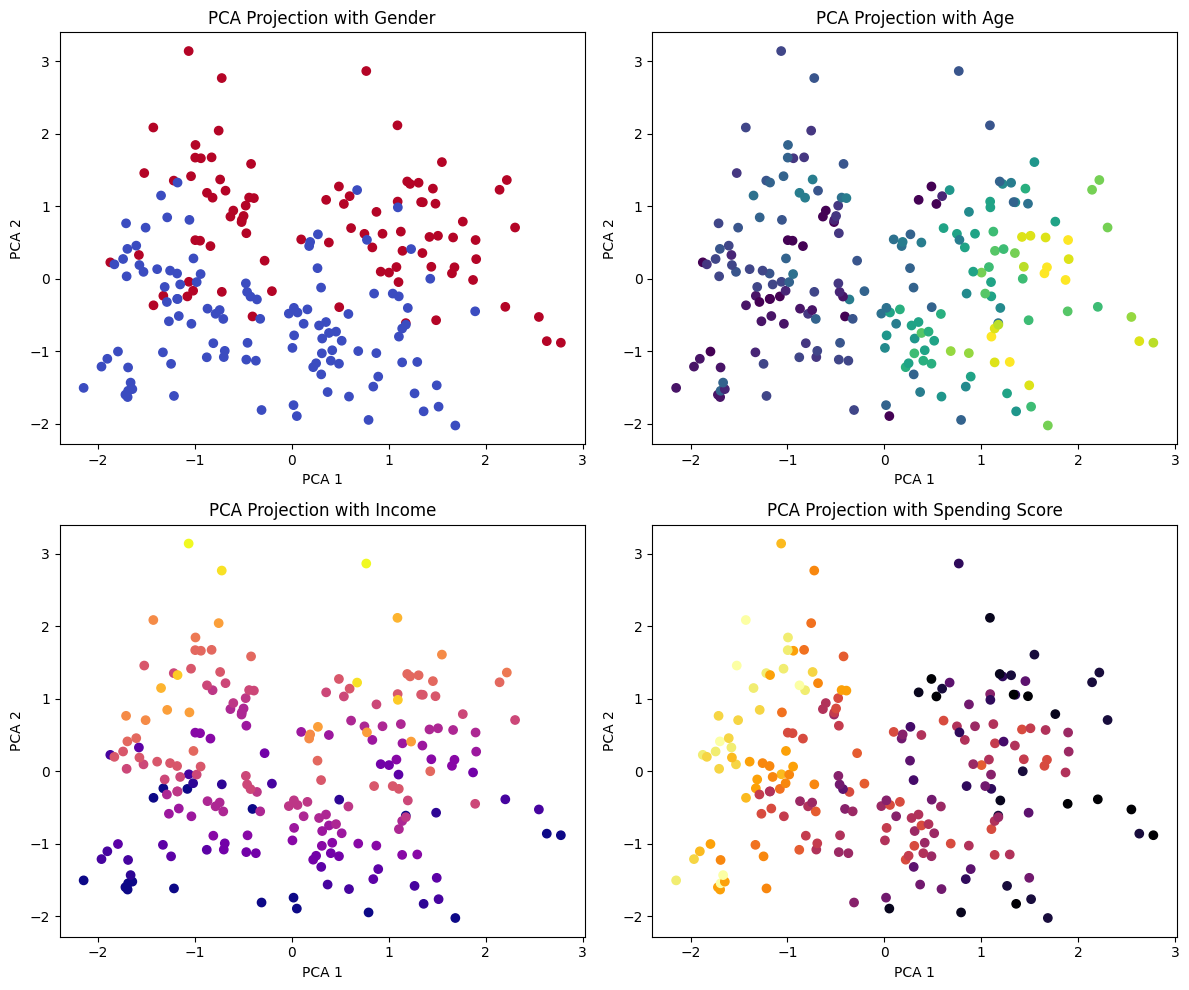

In [12]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# create some feature groups
gender_colors = df['Gender']
age_group = pd.cut(df['Age'], bins=20)
income_group = pd.cut(df['Annual Income (k$)'], bins=20)
spending_group = pd.cut(df['Spending Score (1-100)'], bins=20)

# Encode groups for coloring
age_colors = LabelEncoder().fit_transform(age_group)
income_colors = LabelEncoder().fit_transform(income_group)
spending_colors = LabelEncoder().fit_transform(spending_group)

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=gender_colors, cmap='coolwarm')
axes[0].set_title("PCA Projection with Gender")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=age_colors, cmap='viridis')
axes[1].set_title("PCA Projection with Age")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=income_colors, cmap='plasma')
axes[2].set_title("PCA Projection with Income")
axes[2].set_xlabel("PCA 1")
axes[2].set_ylabel("PCA 2")

axes[3].scatter(X_pca[:, 0], X_pca[:, 1], c=spending_colors, cmap='inferno')
axes[3].set_title("PCA Projection with Spending Score")
axes[3].set_xlabel("PCA 1")
axes[3].set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

From the PCA, we can see that Gender and Income seem to play some sort of role for the PCA 2 variable (i.e., the data splits vertically), whereas spending score and Age seem to play a role in the PCA 1 variable (the data splits horizontally). We can already see how some clusters might form.

# Analysis (Model Building and Training)

To be able to compare models, we need to use scoring algorithms that we have not seen in class yet. That is because we do not know the true labelling of each cluster, so we need to measure the clusters in another way. After some initial research based on the scikit-learn library, according to Pedregosa et al. (2011), we can use three metrics. However, we will use one important metric, the Silhouette Coefficient, to determine the best ranking model.

## Agglomerative Clustering

For Agglomerative Clustering (Hierarchical), we first want to determine where to cut the tree. We'll also need to iterate over different linkage types to see which tree produces the best method. However, let us first use complete linkage.

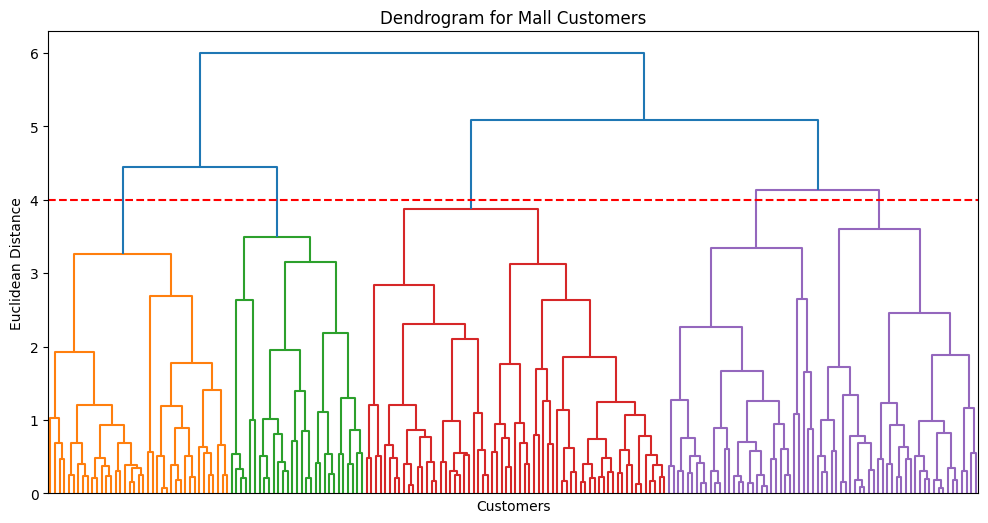

In [13]:
import scipy.cluster.hierarchy as sch

linkage_matrix = sch.linkage(X, method='complete')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title("Dendrogram for Mall Customers")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.axhline(y=4, color='r', linestyle='--')
plt.xticks([])
plt.show()

Using y=4, we can see that there will be 5 clusters. We can see where the (dotted red) line cuts through each of the trees. Using this number (5), we can now perform the Agglomerative Clustering. Now, we could move the cutoff up to 4.2, leaving us with only 4 clusters. We will explore 4 clusters when we iterate later.

In [14]:
from sklearn.cluster import AgglomerativeClustering

agg_model=AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='complete').fit(X)
y_agg = agg_model.fit_predict(X)

Here, we have created the model and predicted the clusters for each value of X. We can now visualize this in 2D and 3D to see how the clusters might look.

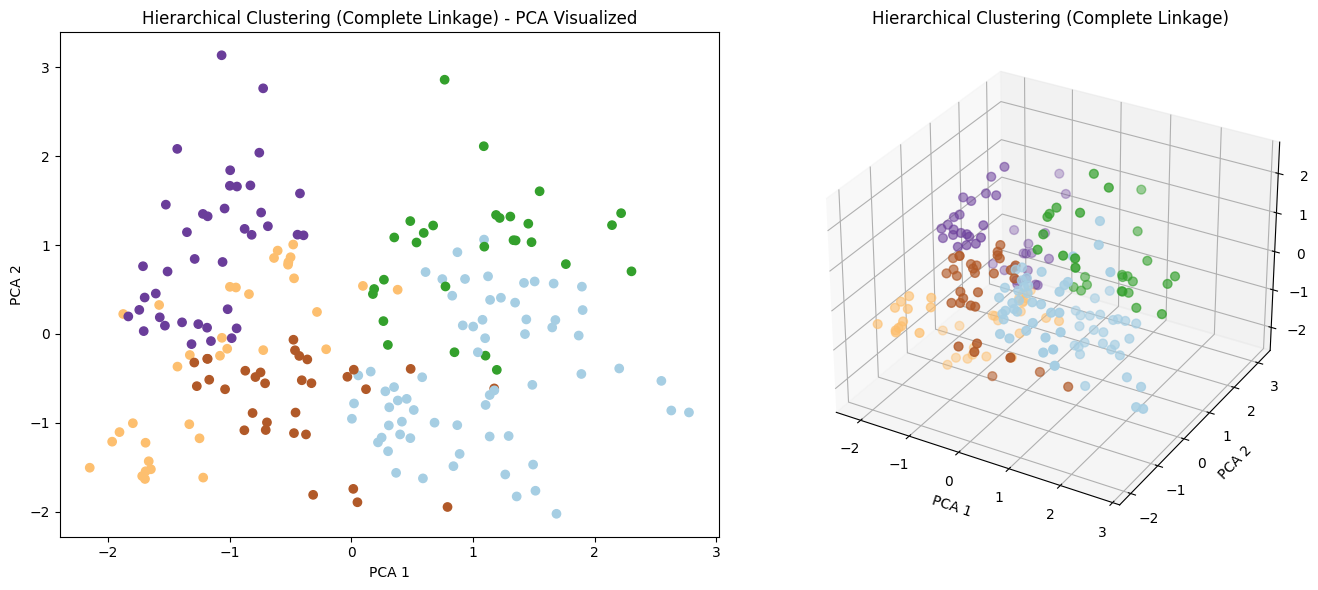

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_agg, cmap='Paired')
ax1.set_title("Hierarchical Clustering (Complete Linkage) - PCA Visualized")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=y_agg, cmap='Paired', s=40)
ax2.set_title("Hierarchical Clustering (Complete Linkage)")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")

plt.tight_layout()
plt.show()

The clustering above doesn't look neatly clustered. Nevertheless, let's investigate some measurements to help us understand how the clustering actually performs so we can compare it to the K-Means clustering.

Since we don't have the actual clustering values, we cannot use "label compute compare" methods to check the accuracy or confusion matrix. However, according to Pedregosa et al. (2011), we can use methods such as Silhouette Coefficient, Calinski-Harabasz Index, and Davies-Bouldin Index, as these do not require the true y-values.

* **Silhouette Coefficient (SC):** This will calculate how well the groups (clusters) fit the data. A score of 1 is perfect. A score of 0 means overlapping clusters, and finally, a score of -1 means incorrect clustering labels.
* **Calinski-Harabasz Index (CHI):** This is also known as the Variance Ratio Criterion. Again, it measures how dense each cluster is and how well separated it is from each other. The higher the score, the better.
* **Davies-Bouldin Index (DBI):** Similar to the other metrics, it looks at how tight each cluster is and how far away it is from each other. However, the closer to zero, the better.

In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

agg_silhouette = silhouette_score(X, y_agg)
agg_dbs = davies_bouldin_score(X, y_agg)
agg_chs = calinski_harabasz_score(X, y_agg)

print(f"Hierarchical Clustering (Complete Linkage) Silhouette Coefficient: {agg_silhouette:.3f}")
print(f"Hierarchical Clustering (Complete Linkage) Calinski-Harabasz Index: {agg_chs:.2f}")
print(f"Hierarchical Clustering (Complete Linkage) Davies-Bouldin Index: {agg_dbs:.3f}")

Hierarchical Clustering (Complete Linkage) Silhouette Coefficient: 0.243
Hierarchical Clustering (Complete Linkage) Calinski-Harabasz Index: 56.86
Hierarchical Clustering (Complete Linkage) Davies-Bouldin Index: 1.378


Looking at the scoring, we can see that the DBI is not close to 0. The SC is also closer to 0 than to 1. Finally, the CHI is not that high (we would expect it to be in the hundreds for excellent clustering). The scores (DBI, SC, and CHI) show that our clusters are not very performant. Let us look at another way to cluster.

## K-Means Clustering

Thanks to the dendrogram, we already have an idea of the number of clusters. We can use the same number of clusters as the hierarchical model, which will give us a good baseline for comparison.

First, create the model and predict the labels (clusters).

In [17]:
from sklearn.cluster import KMeans

k_model = KMeans(n_clusters=5, n_init=10).fit(X)
y_k = k_model.predict(X)

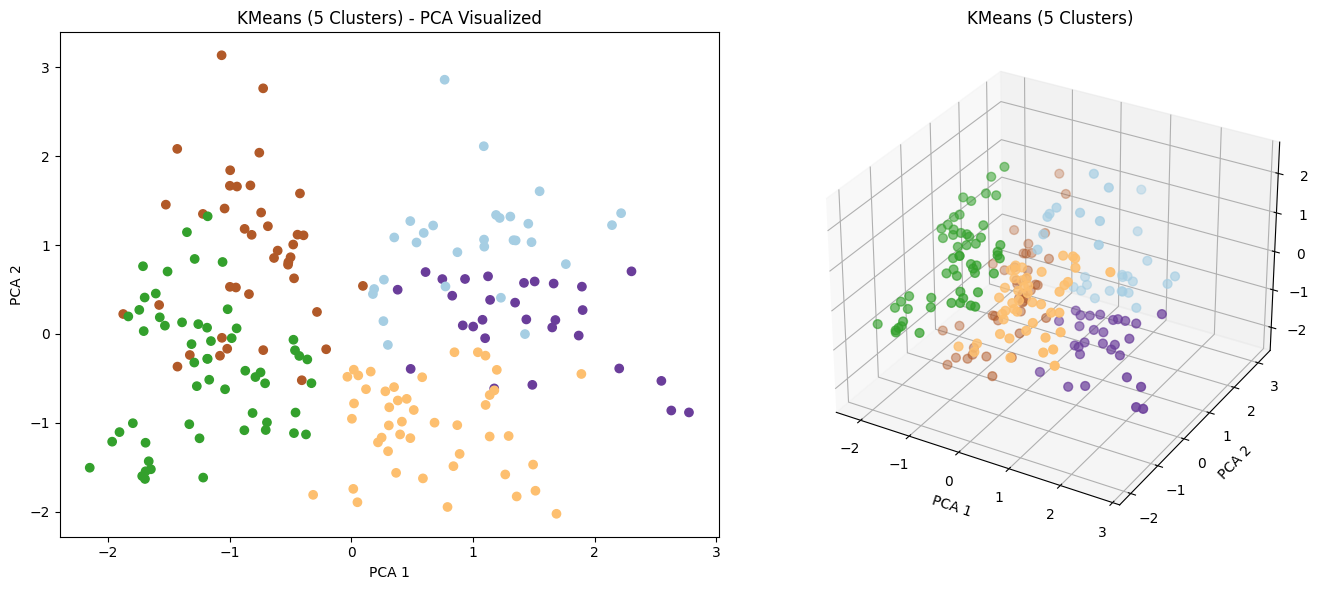

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_k, cmap='Paired')
ax1.set_title("KMeans (5 Clusters) - PCA Visualized")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=y_k, cmap='Paired', s=40)
ax2.set_title("KMeans (5 Clusters)")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")

plt.tight_layout()
plt.show()

Based on the PCA plots, the clusters look much better. There is less overlap, and they look more distinct. We'll use the same scoring as for the hierarchical clustering model.

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

k_silhouette = silhouette_score(X, y_k)
k_dbs = davies_bouldin_score(X, y_k)
k_chs = calinski_harabasz_score(X, y_k)

print(f"KMeans (5 Clusters) Silhouette Coefficient: {k_silhouette:.3f}")
print(f"KMeans (5 Clusters) Calinski-Harabasz Index: {k_chs:.2f}")
print(f"KMeans (5 Clusters) Davies-Bouldin Index: {k_dbs:.3f}")

KMeans (5 Clusters) Silhouette Coefficient: 0.317
KMeans (5 Clusters) Calinski-Harabasz Index: 70.98
KMeans (5 Clusters) Davies-Bouldin Index: 1.144


The scores look better compared to the above. The SC is closer to 1 (although there is still a lot of room for improvement). The CHI is also bigger, at 70, compared to 50. Lastly, the DBI is also slightly lower.

# Results and Tuning

The results are not great. Even with K-Means of 5 Clusters, the Silhouette Coefficient is only 0.32. The low coefficient indicates there is still a lot of overlap. So, we first want to iterate over the models to see if we can find a better Silhouette Coefficient.

## Agglomerative Clustering

Let us first draw some dendrograms of the different linkages. These charts will help identify different cluster numberings.

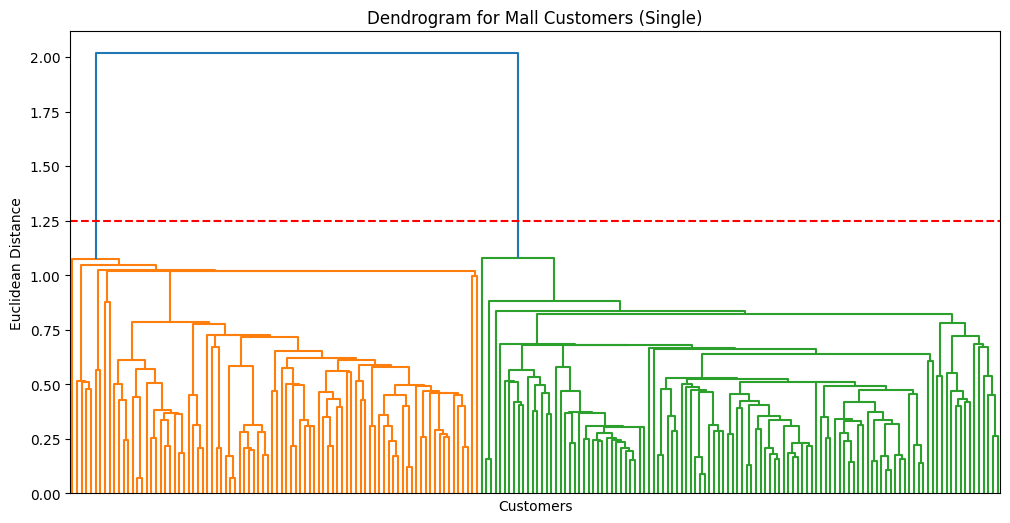

In [20]:
import scipy.cluster.hierarchy as sch

linkage_matrix = sch.linkage(X, method='single')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title("Dendrogram for Mall Customers (Single)")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.axhline(y=1.25, color='r', linestyle='--')
plt.xticks([])
plt.show()

The chart above is a very flat dendrogram. We put the line at 1.25, which would only give two clusters.

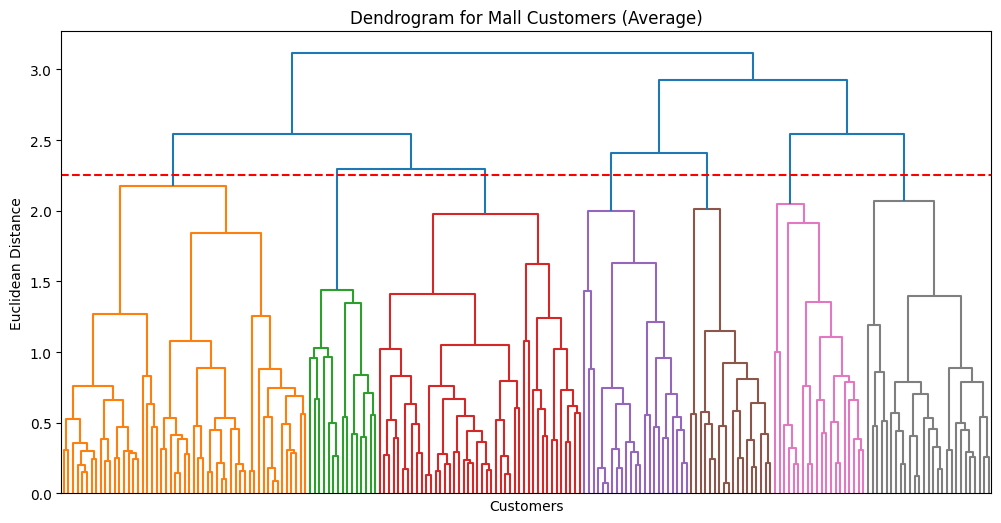

In [21]:
import scipy.cluster.hierarchy as sch

linkage_matrix = sch.linkage(X, method='average')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title("Dendrogram for Mall Customers (Average)")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.axhline(y=2.25, color='r', linestyle='--')
plt.xticks([])
plt.show()

Using a cutoff at 2.25, we can see 7 clusters when using the average.

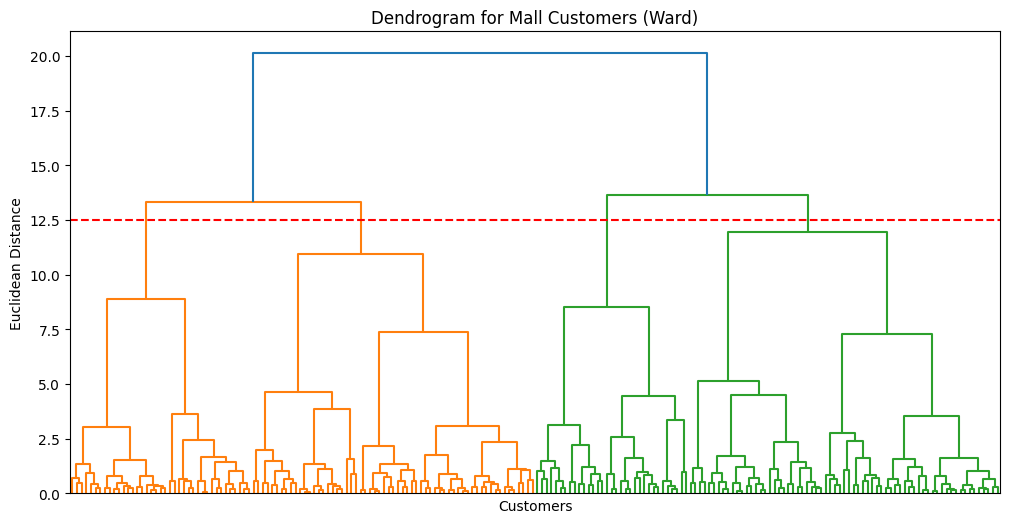

In [22]:
import scipy.cluster.hierarchy as sch

linkage_matrix = sch.linkage(X, method='ward')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title("Dendrogram for Mall Customers (Ward)")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.axhline(y=12.5, color='r', linestyle='--')
plt.xticks([])
plt.show()

Interestingly, with Ward, we would have 2, 4, 5, or 6 clusters (depending on where we want to cut off).

We will do a manual iteration (as we cannot use GridSearch) across the number of clusters (as we have determined above) and the linkage. We will then store these in an array and create a dataframe allowing us to sort and display.

In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

results = []

for n in [2, 4, 5, 6, 7]:
    for linkage in ['complete', 'ward', 'average', 'single']:
        try:
            m = AgglomerativeClustering(n_clusters=n, linkage=linkage, metric='euclidean')
            labels = m.fit_predict(X)

            silhouette = silhouette_score(X, labels)
            ch_score = calinski_harabasz_score(X, labels)
            db_score = davies_bouldin_score(X, labels)

            results.append({
                'n_clusters': n,
                'linkage': linkage,
                'silhouette': silhouette,
                'calinski_harabasz': ch_score,
                'davies_bouldin': db_score,
                'labels': labels
            })

        except Exception as e:
            print(f"Skipped (n={n}, linkage={linkage}): {e}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
results_df.sort_values(by='silhouette', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df


,n_clusters,linkage,silhouette,calinski_harabasz,davies_bouldin,labels
0,7,ward,0.345558,72.749743,1.010832,"[2, 2, 3, 1, 3, 1, 3, 1, 4, 1, 4, 1, 3, 1, 2, ..."
1,7,average,0.343253,69.612631,1.009740,"[5, 5, 4, 0, 4, 0, 4, 0, 1, 0, 1, 0, 4, 0, 5, ..."
2,6,average,0.321214,66.919236,1.066682,"[5, 5, 0, 1, 0, 1, 0, 1, 4, 1, 4, 1, 0, 1, 5, ..."
3,6,ward,0.310245,70.227089,1.072908,"[5, 5, 3, 1, 3, 1, 3, 1, 4, 1, 4, 1, 3, 1, 5, ..."
4,5,average,0.307458,66.171911,1.167773,"[0, 0, 2, 1, 2, 1, 2, 1, 4, 1, 4, 1, 2, 1, 0, ..."
5,7,complete,0.304991,66.006568,1.037706,"[1, 4, 1, 6, 1, 6, 1, 6, 5, 6, 5, 6, 2, 6, 1, ..."
6,5,ward,0.286994,64.468707,1.219773,"[0, 0, 3, 0, 3, 0, 3, 0, 4, 0, 4, 0, 3, 0, 0, ..."
7,6,complete,0.283890,63.743706,1.236563,"[4, 0, 4, 0, 4, 0, 4, 0, 5, 0, 5, 0, 2, 0, 4, ..."
8,2,average,0.277604,66.906291,1.611694,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, ..."
9,2,single,0.277604,66.906291,1.611694,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, ..."


The table above shows there are likely 7 clusters, and the Ward method produces the best clustering. However, this is still not a very good score.

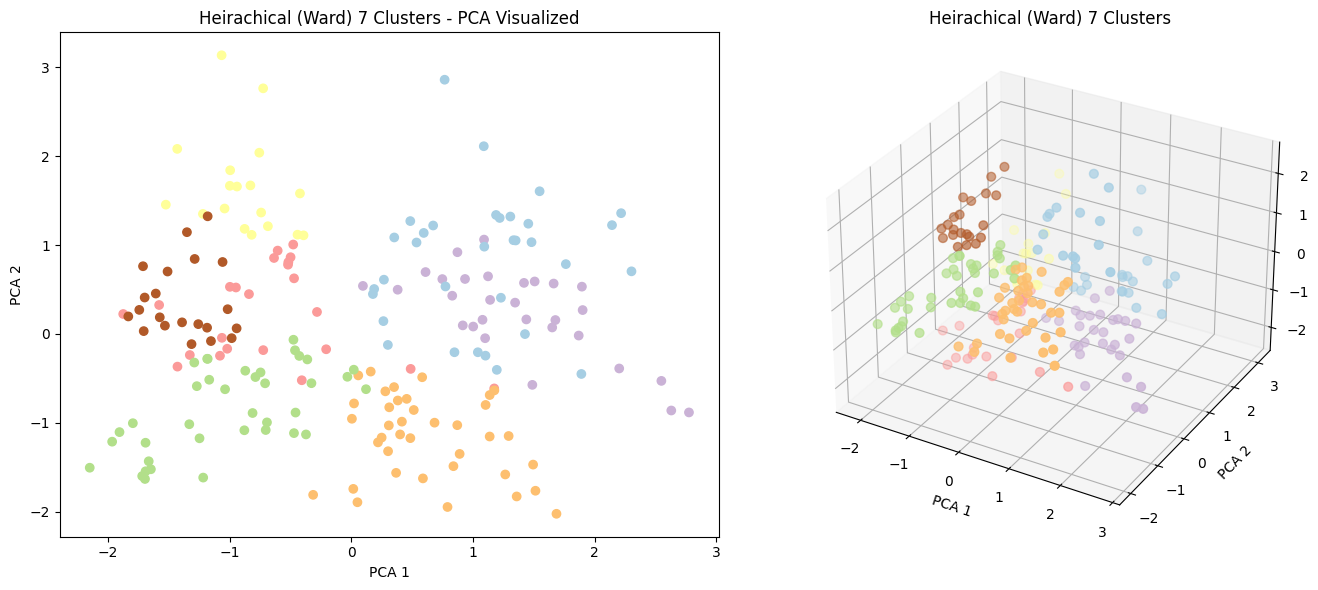

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=results_df.iloc[0]['labels'], cmap='Paired')
ax1.set_title("Heirachical (Ward) 7 Clusters - PCA Visualized")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=results_df.iloc[0]['labels'], cmap='Paired', s=40)
ax2.set_title("Heirachical (Ward) 7 Clusters")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")

plt.tight_layout()
plt.show()

From looking at the plot, we can see that the 2D plot has a bit of overlap. On the 3D plot, you can see they separate a bit better.

## K-Means Clustering

We will iterate over the "number of clusters" for K-Means.

In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

results = []

for n in [2, 3, 4, 5, 6, 7]:
    try:
        m = KMeans(n_clusters=n, n_init=10)
        labels = m.fit_predict(X)

        silhouette = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)

        results.append({
            'n_clusters': n,
            'silhouette': silhouette,
            'calinski_harabasz': ch_score,
            'davies_bouldin': db_score,
            'labels': labels
        })

    except Exception as e:
        print(f"Skipped (n={n}): {e}")

# Convert results to DataFrame and display
results_df_k = pd.DataFrame(results)
results_df_k.sort_values(by='silhouette', ascending=False, inplace=True)
results_df_k.reset_index(drop=True, inplace=True)
results_df_k

,n_clusters,silhouette,calinski_harabasz,davies_bouldin,labels
0,7,0.357913,76.808253,0.978906,"[1, 1, 4, 4, 4, 4, 2, 4, 3, 4, 3, 4, 2, 4, 3, ..."
1,6,0.321342,73.560499,1.034872,"[0, 0, 5, 5, 5, 5, 2, 5, 3, 5, 3, 5, 2, 5, 3, ..."
2,5,0.317994,71.214941,1.149226,"[2, 2, 3, 1, 3, 1, 3, 1, 4, 1, 4, 1, 3, 1, 4, ..."
3,4,0.299278,69.198646,1.282470,"[0, 0, 1, 3, 1, 3, 1, 3, 2, 3, 2, 3, 1, 3, 2, ..."
4,3,0.259513,66.772770,1.357408,"[1, 1, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, ..."
5,2,0.251815,71.020516,1.613751,"[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..."


From the table above, we can see again that 7 clusters perform the best. K-Means performs better than the hierarchical clustering model. Nevertheless, the SI score is still very low. This means that we still have not really separated our clusters.

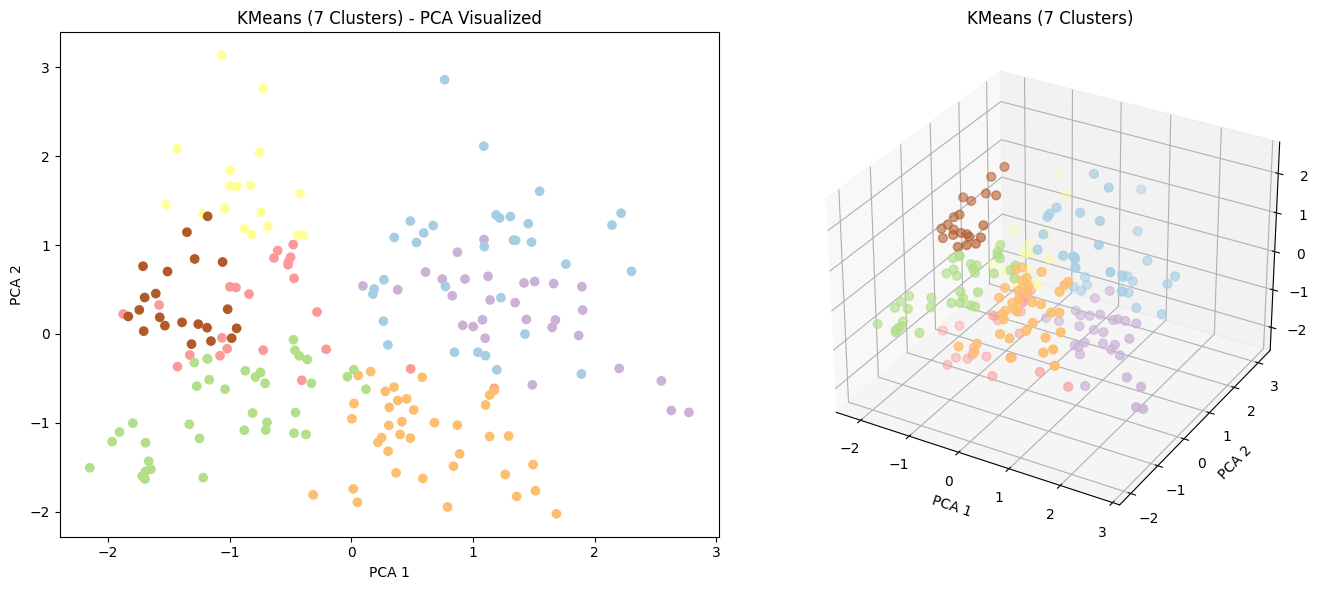

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=results_df.iloc[0]['labels'], cmap='Paired')
ax1.set_title("KMeans (7 Clusters) - PCA Visualized")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")

# 3D plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=results_df.iloc[0]['labels'], cmap='Paired', s=40)
ax2.set_title("KMeans (7 Clusters)")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")

plt.tight_layout()
plt.show()

## DBSCAN - Density-Based Spatial Clustering of Applications with Noise

Even though it is not in our original clustering model plan, we want to try a third clustering algorithm to see if we can improve the scores. There are two parameters we want to care about:
* **eps:** The maximum distance between two points is considered a neighborhood.
* **min_samples:** The minimum number of points needed to create a core point. The higher the number, the denser the clusters.

If we go back to the dendrograms above, the Euclidean distance of 0.5 could be a reasonable starting point for eps. We will leave min_samples at the default of 5.

In [27]:
from sklearn.cluster import DBSCAN

d_model = DBSCAN(eps=0.5, min_samples=5)
y_d = d_model.fit_predict(X)

In [28]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

d_silhouette = silhouette_score(X, y_d)
d_dbs = davies_bouldin_score(X, y_d)
d_chs = calinski_harabasz_score(X, y_d)

print(f"DBSCAN Silhouette Coefficient: {d_silhouette:.3f}")
print(f"DBSCAN Calinski-Harabasz Index: {d_chs:.2f}")
print(f"DBSCAN Davies-Bouldin Index: {d_dbs:.3f}")

DBSCAN Silhouette Coefficient: 0.012
DBSCAN Calinski-Harabasz Index: 12.10
DBSCAN Davies-Bouldin Index: 1.389


Unfortunately, DBSCAN does not perform any better than the other two models (it performs worse). We will not iterate on it further as it will not improve enough to outperform K-Means or Agglomerative clustering.

## Discussion

In [29]:
results = {
    'Model': ['Hierarchical Clustering (Complete Linkage) - 5 Clusters', 'Hierarchical Clustering (Ward Linkage) - 7 Clusters', 'KMeans - 5 Clusters', 'KMeans - 7 Clusters'],
    'Silhouette Coefficient': [agg_silhouette, results_df.iloc[0]['silhouette'], k_silhouette, results_df_k.iloc[0]['silhouette']],
    'Calinski-Harabasz Index': [agg_chs, results_df.iloc[0]['calinski_harabasz'], k_chs, results_df_k.iloc[0]['calinski_harabasz']],
    'Davies-Bouldin Index': [agg_dbs, results_df.iloc[0]['davies_bouldin'], k_dbs, results_df_k.iloc[0]['davies_bouldin']]
}
df_performance = pd.DataFrame(results).sort_values(by=['Silhouette Coefficient'], ascending=False)
df_performance

,Model,Silhouette Coefficient,Calinski-Harabasz Index,Davies-Bouldin Index
3,KMeans - 7 Clusters,0.357913,76.808253,0.978906
1,Hierarchical Clustering (Ward Linkage) - 7 Clu...,0.345558,72.749743,1.010832
2,KMeans - 5 Clusters,0.316903,70.975099,1.144003
0,Hierarchical Clustering (Complete Linkage) - 5...,0.243309,56.857712,1.377666


As the results above show, K-Means with 7 Clusters performed the best after we iterated on our model. Now, I want to explain who is in each of the clusters and how we can use that data to target them.

We will bring the best clustering labels back to our original data frame, which will allow us to gain insights when we start grouping.

In [30]:
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = results_df_k.iloc[0]['labels']
df_with_clusters['Gender'] = le.inverse_transform(df_with_clusters['Gender'])

# Only keep numeric columns for aggregation
numeric_cols = df_with_clusters.select_dtypes(include='number').columns

# Group by cluster and compute descriptive statistics
summary_stats = df_with_clusters.groupby('Cluster')[numeric_cols].agg(['min', 'mean', 'max', 'std'])
summary_stats

Age                          Annual Income (k$)                  \
        min       mean max       std                min       mean  max   
Cluster                                                                   
0        19  37.769231  54  9.369344                 73  91.461538  137   
1        18  24.608696  38  6.235814                 15  40.695652   67   
2        35  50.875000  68  8.904587                 18  49.175000   79   
3        37  56.235294  70  9.224667                 19  53.676471   93   
4        18  25.945946  35  5.152917                 16  42.216216   76   
5        27  33.277778  40  4.389902                 69  87.111111  137   
6        27  32.545455  40  3.432718                 69  85.272727  120   

                   Spending Score (1-100)                           Cluster  \
               std                    min       mean max        std     min   
Cluster                                                                       
0        17.351036                      1  16.115385  39   9.339494       0   
1        17.358348                     35  61.478261  92  15.948410       1   
2        15.123233                      5  39.700000  59  15.857054       2   
3        18.995567                      3  36.235294  60  17.974829       3   
4        18.739642                      6  57.459459  99  20.539386       4   
5        18.929867                     63  82.666667  97  11.103788       5   
6        14.286796                     58  80.590909  95   9.158182       6   

                       
        mean max  std  
Cluster                
0        0.0   0  0.0  
1        1.0   1  0.0  
2        2.0   2  0.0  
3        3.0   3  0.0  
4        4.0   4  0.0  
5        5.0   5  0.0  
6        6.0   6  0.0

In [31]:
gender_dist = df_with_clusters.groupby(['Cluster', 'Gender']).size().unstack()
gender_dist

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Gender,Female,Male
Cluster,,
0,13.0,13.0
1,NaN,23.0
2,40.0,NaN
3,NaN,34.0
4,37.0,NaN
5,NaN,18.0
6,22.0,NaN


We want to visualize the data to offer meaningful descriptions of each cluster for our marketing department.

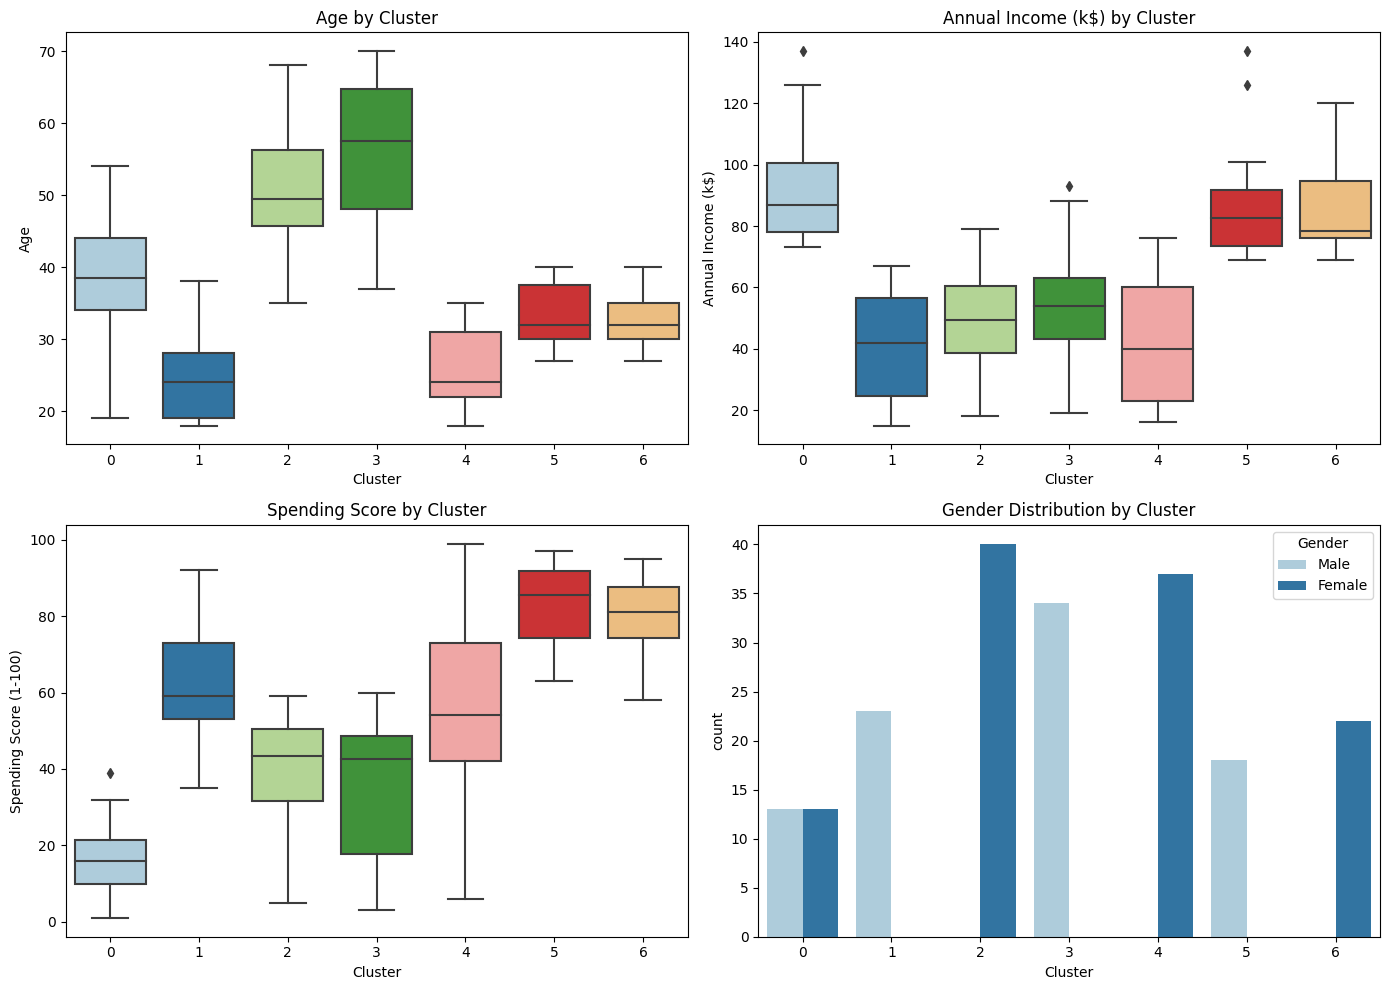

In [32]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()


sns.boxplot(data=df_with_clusters, x='Cluster', ax=axes[0], y='Age', palette='Paired')
axes[0].set_title("Age by Cluster")

sns.boxplot(data=df_with_clusters, x='Cluster', ax=axes[1], y='Annual Income (k$)', palette='Paired')
axes[1].set_title("Annual Income (k$) by Cluster")

sns.boxplot(data=df_with_clusters, x='Cluster', ax=axes[2], y='Spending Score (1-100)', palette='Paired')
axes[2].set_title("Spending Score by Cluster")

sns.countplot(data=df_with_clusters, x='Cluster', hue='Gender', ax=axes[3], palette='Paired')
axes[3].set_title("Gender Distribution by Cluster")

plt.tight_layout()
plt.show()
    

Based on the charts above, we have the following clusters:

* **Cluster 1:** Young (professional) males (19-31) with a lower annual income. They have an above-average spending score.
* **Cluster 2:** Young (professional) females (22-31) with a lower annual income. They have an average spending score with a wide spread.
* **Cluster 3:** Older (retired) males (52-67) with a mid-to-low income. They have a lower-than-average spending score.
* **Cluster 4:** Career professional males (30-38) with a higher annual income. They have a very high spending score.
* **Cluster 5:** Career professional females (30-35) with a higher annual income. They have a very high spending score as well.
* **Cluster 6:** Middle-aged males (32-47) with a higher annual income. They have a low spending score.
* **Cluster 7:** Middle-aged females (44-54) with a mid-level income. They have a below-average spending score with a wide spread.

## Improvements

Many improvements can be made. For one, the Silhouette Coefficient is still very low. This means that even though we have some defined clusters, there is still some overlap, but at least there is no wrongly classified data. So, to improve this, I would potentially go through some other clustering methods (https://scikit-learn.org/stable/modules/clustering.html). I would also look for outliers in the data, as this might be skewing the potential clusters.

Since the data does not have truth labels, the clusters are just assumptions based on similar patterns. We can learn from our marketing how the marketing material affects the spending score in the mall. By gathering new data, we can tune the models more.

## Conclusion

Overall, we formed some clusters, but the results were unclear. With a Silhouette Coefficient of 0.362, it's still far away from 1. This means the clusters aren't well separated, and there is still some overlap between them. We can see this with the age breakdown above in the clusters. Clusters 1, 4, and 6 all overlap with Age and gender.

However, we can still use these clusters to do some personalized marketing. For example, male and female high-income earners with high spending scores can be retargeted for loyalty. Young professionals with lower spending scores can be targeted for events or sales. Once we get more data, we can better define the clusters.

Overall, I think it's a good start, but it still has a long way to go to really improve the mall.

# References

Aitken, A. M. (2025). Titanic - ML from Disaster (Supervised Learning), 8. Retrieved 05/13/2025 from https://www.kaggle.com/code/alexandermaitken/titanic-ml-from-disaster-supervised-learning#Titanic---ML-from-Disaster

Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830.
* https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
* https://scikit-learn.org/stable/modules/clustering.html

Choudhary, V. (2012). Mall Customer Segmentation Data, 1. Retrieved 05/13/2025 from https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python.



You can find a copy of the notebook in my Github: https://github.com/alexmaitken/csca5632-final/